In [6]:
!pip install google

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torch import Tensor
from functools import partial
from typing import Any, Callable, List, Optional, Type, Union

import torchvision

#from google.colab import drive
from torchvision  import datasets
from torchvision  import transforms
from torchvision  import transforms, utils

import matplotlib.pyplot as plt

/Users/alexrust/myenv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#drive.mount('/content/drive')
DATA_DIR = '/Users/alexrust/Documents/мага_2_курс/CV/Dataset Food/' #/content/drive/MyDrive/Food/'


In [3]:
def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=5,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )

def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


In [4]:
class BasicBlock(nn.Module):
    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1:
            raise ValueError("BasicBlock only supports groups=1")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [5]:
class Bottleneck(nn.Module):

    contraction: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = inplanes // self.contraction
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes)
        self.bn3 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


In [6]:
class ResNet(nn.Module):
    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        layers: List[int],
        num_classes: int = 1000,
        zero_init_residual: bool = False,
        groups: int = 1,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            replace_stride_with_dilation = [False, False, False]
        self.groups = groups
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 32, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck) and m.bn3.weight is not None:
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock) and m.bn2.weight is not None:
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        planes: int,
        blocks: int,
        stride: int = 1,
        dilate: bool = False,
    ) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes, stride),
                norm_layer(planes),
            )

        layers = []
        layers.append(
            block(
                self.inplanes, planes, stride, downsample, self.groups, previous_dilation, norm_layer
            )
        )
        self.inplanes = planes
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def forward(self, x: Tensor) -> Tensor:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


In [7]:
train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(p=0.45),
        transforms.RandomRotation(10),
        transforms.RandomVerticalFlip(p=0.45),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

val_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [8]:
train_dir = DATA_DIR + 'train'
val_dir = DATA_DIR + 'val'

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=32, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=32, shuffle=False)

In [9]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

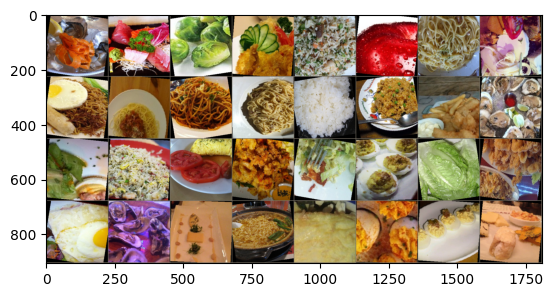

In [10]:
# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

In [11]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    best_loss = np.inf
    best_acc = 0
    loss_train = []
    loss_val = []
    acc_train = []
    acc_val = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')

        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_acc = 0.0

            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    preds = outputs.argmax(dim=1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item()
                running_acc += (preds == labels.data).float().mean()
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            if phase == 'train':
                loss_train.append(epoch_loss)
                acc_train.append(epoch_acc)

            if phase == 'val':
                loss_val.append(epoch_loss)
                acc_val.append(epoch_acc)
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_loss = epoch_loss
                torch.save(model,f'{DATA_DIR}bestModel.pt')

        print()

    print(f'Best val Acc: {best_acc:4f}')

    return model, loss_train, acc_train, loss_val, acc_val

In [12]:
model_ft = ResNet(BasicBlock, [3, 4, 3, 2], num_classes=7)
model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = torch.optim.Adam(model_ft.parameters(), lr=1e-3)

exp_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer_ft, gamma=0.9)

In [13]:
model_ft, loss_train, acc_train, loss_val, acc_val = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
train Loss: 1.6737 Acc: 0.3828
val Loss: 1.6311 Acc: 0.4269

Epoch 1/9
train Loss: 1.5245 Acc: 0.4268
val Loss: 2.1801 Acc: 0.2799

Epoch 2/9
train Loss: 1.4462 Acc: 0.4547
val Loss: 1.3612 Acc: 0.4921

Epoch 3/9
train Loss: 1.4116 Acc: 0.4749
val Loss: 1.4813 Acc: 0.4734

Epoch 4/9
train Loss: 1.3513 Acc: 0.4990
val Loss: 1.2178 Acc: 0.5521

Epoch 5/9
train Loss: 1.3348 Acc: 0.4988
val Loss: 1.1309 Acc: 0.5896

Epoch 6/9
train Loss: 1.2959 Acc: 0.5226
val Loss: 1.2309 Acc: 0.5619

Epoch 7/9
train Loss: 1.2732 Acc: 0.5216
val Loss: 1.0838 Acc: 0.6007

Epoch 8/9
train Loss: 1.2110 Acc: 0.5481
val Loss: 1.0580 Acc: 0.6196

Epoch 9/9
train Loss: 1.2051 Acc: 0.5571
val Loss: 1.0946 Acc: 0.6152

Best val Acc: 0.619647


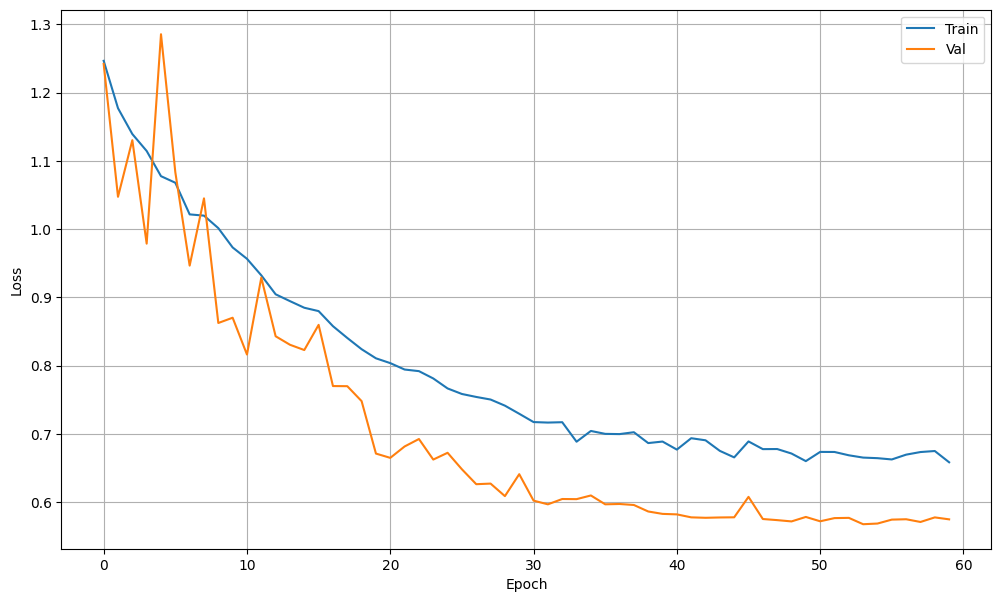

In [48]:
plt.figure(figsize=(12, 7))
plt.plot(loss_train, label="Train")
plt.plot(loss_val,label="Val")
plt.grid()
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

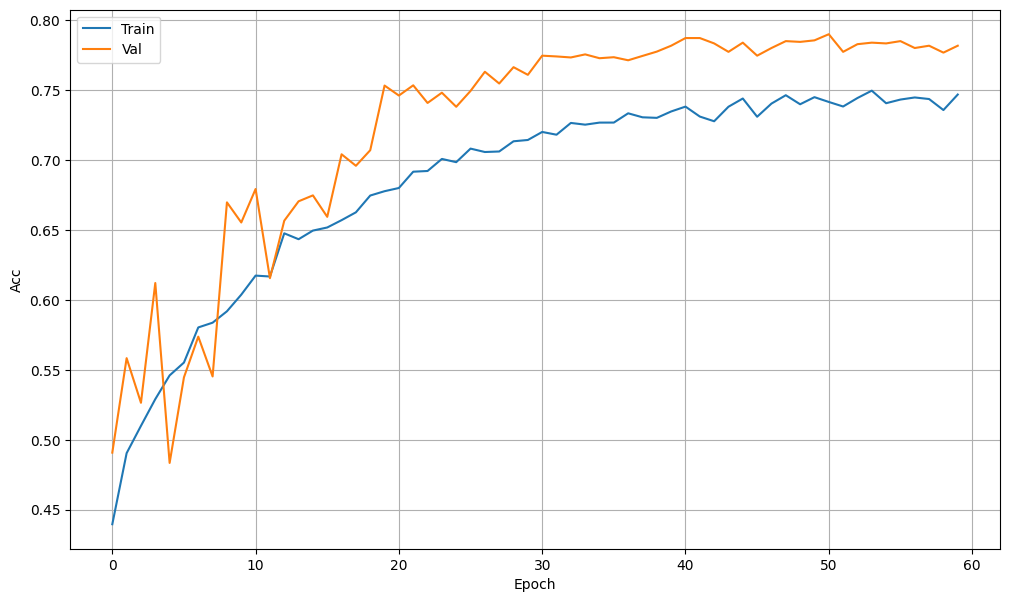

In [49]:
val_acc = [x.cpu().numpy() for x in acc_val]
train_acc = [x.cpu().numpy() for x in acc_train]

plt.figure(figsize=(12, 7))
plt.plot(train_acc, label="Train")
plt.plot(val_acc ,label="Val")
plt.grid()
plt.legend()
plt.ylabel("Acc")
plt.xlabel("Epoch")
plt.show()